In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.tools.visualization import plot_histogram
import pandas as pd
from fractions import Fraction


In [11]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

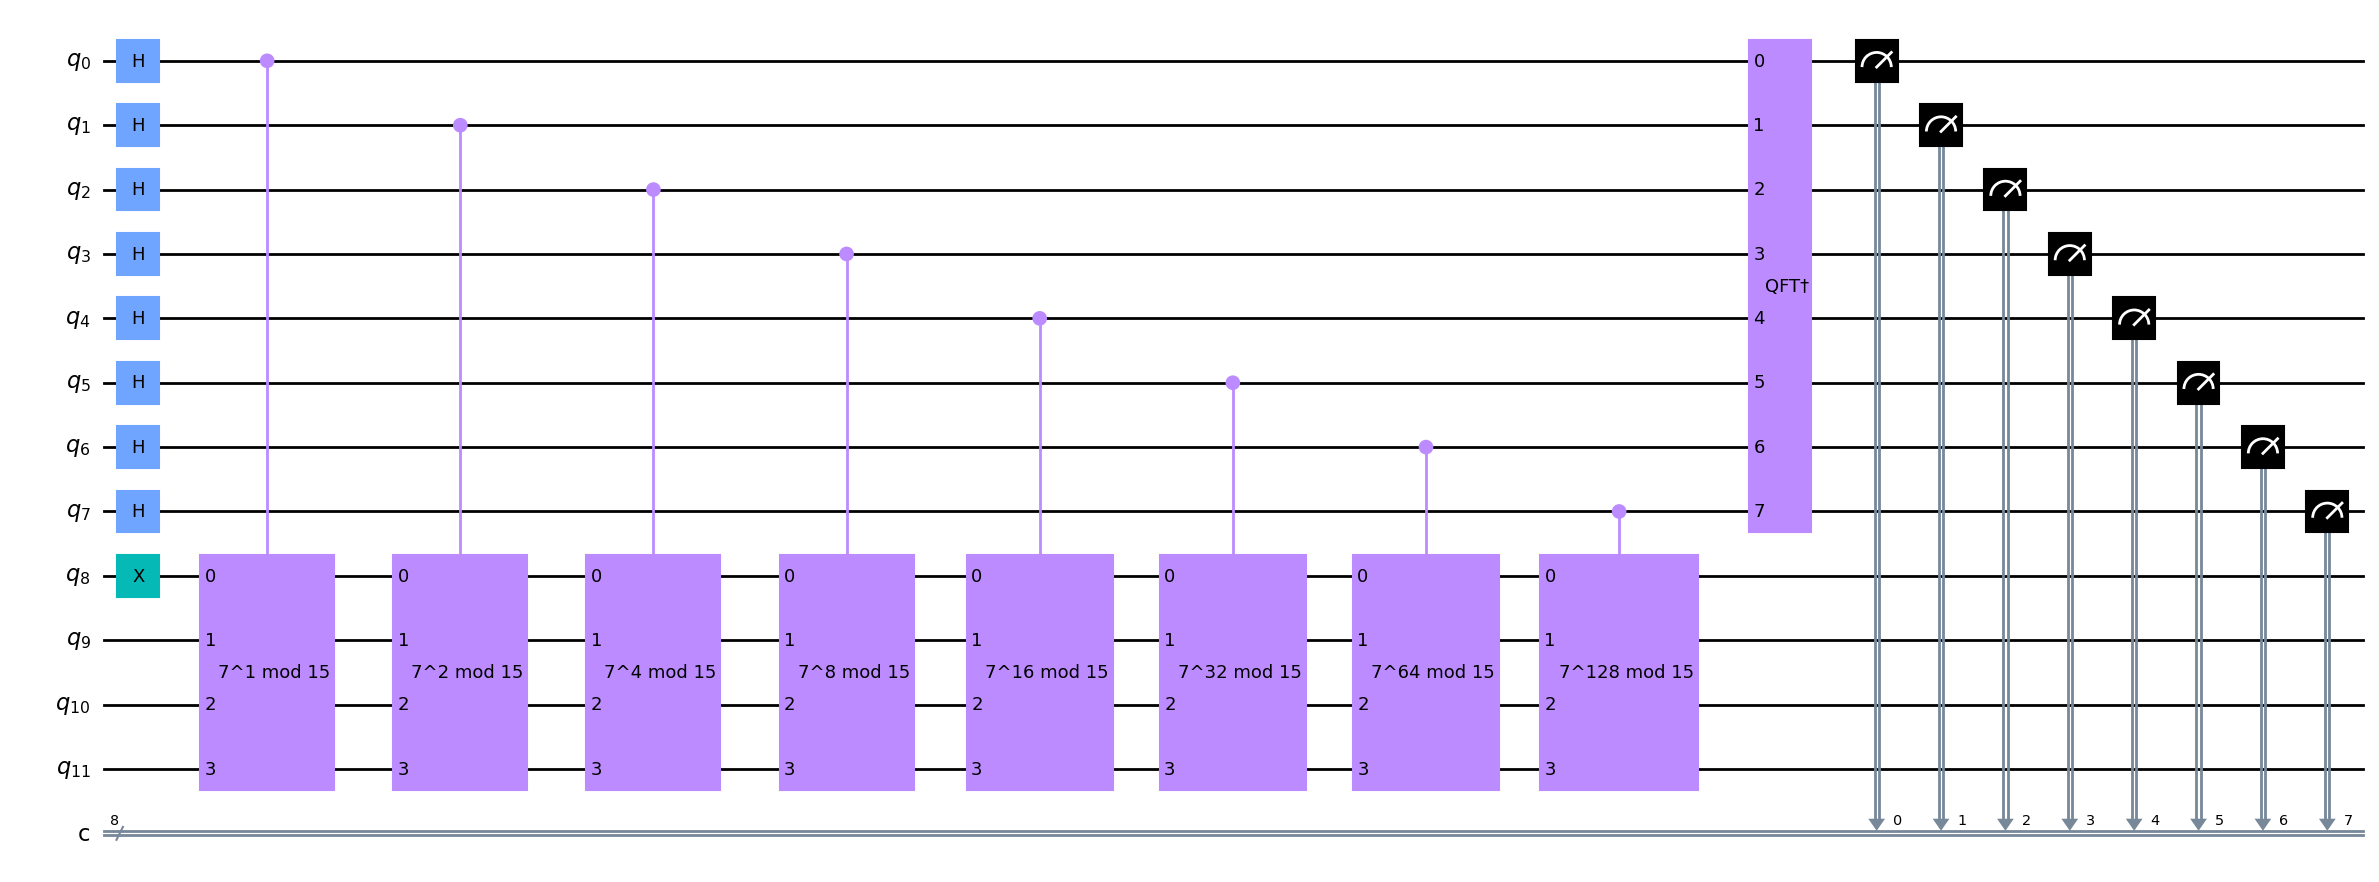

In [20]:
N_COUNT = 8
a = 7

qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw("mpl", fold=-1)  # -1 means 'do not fold'


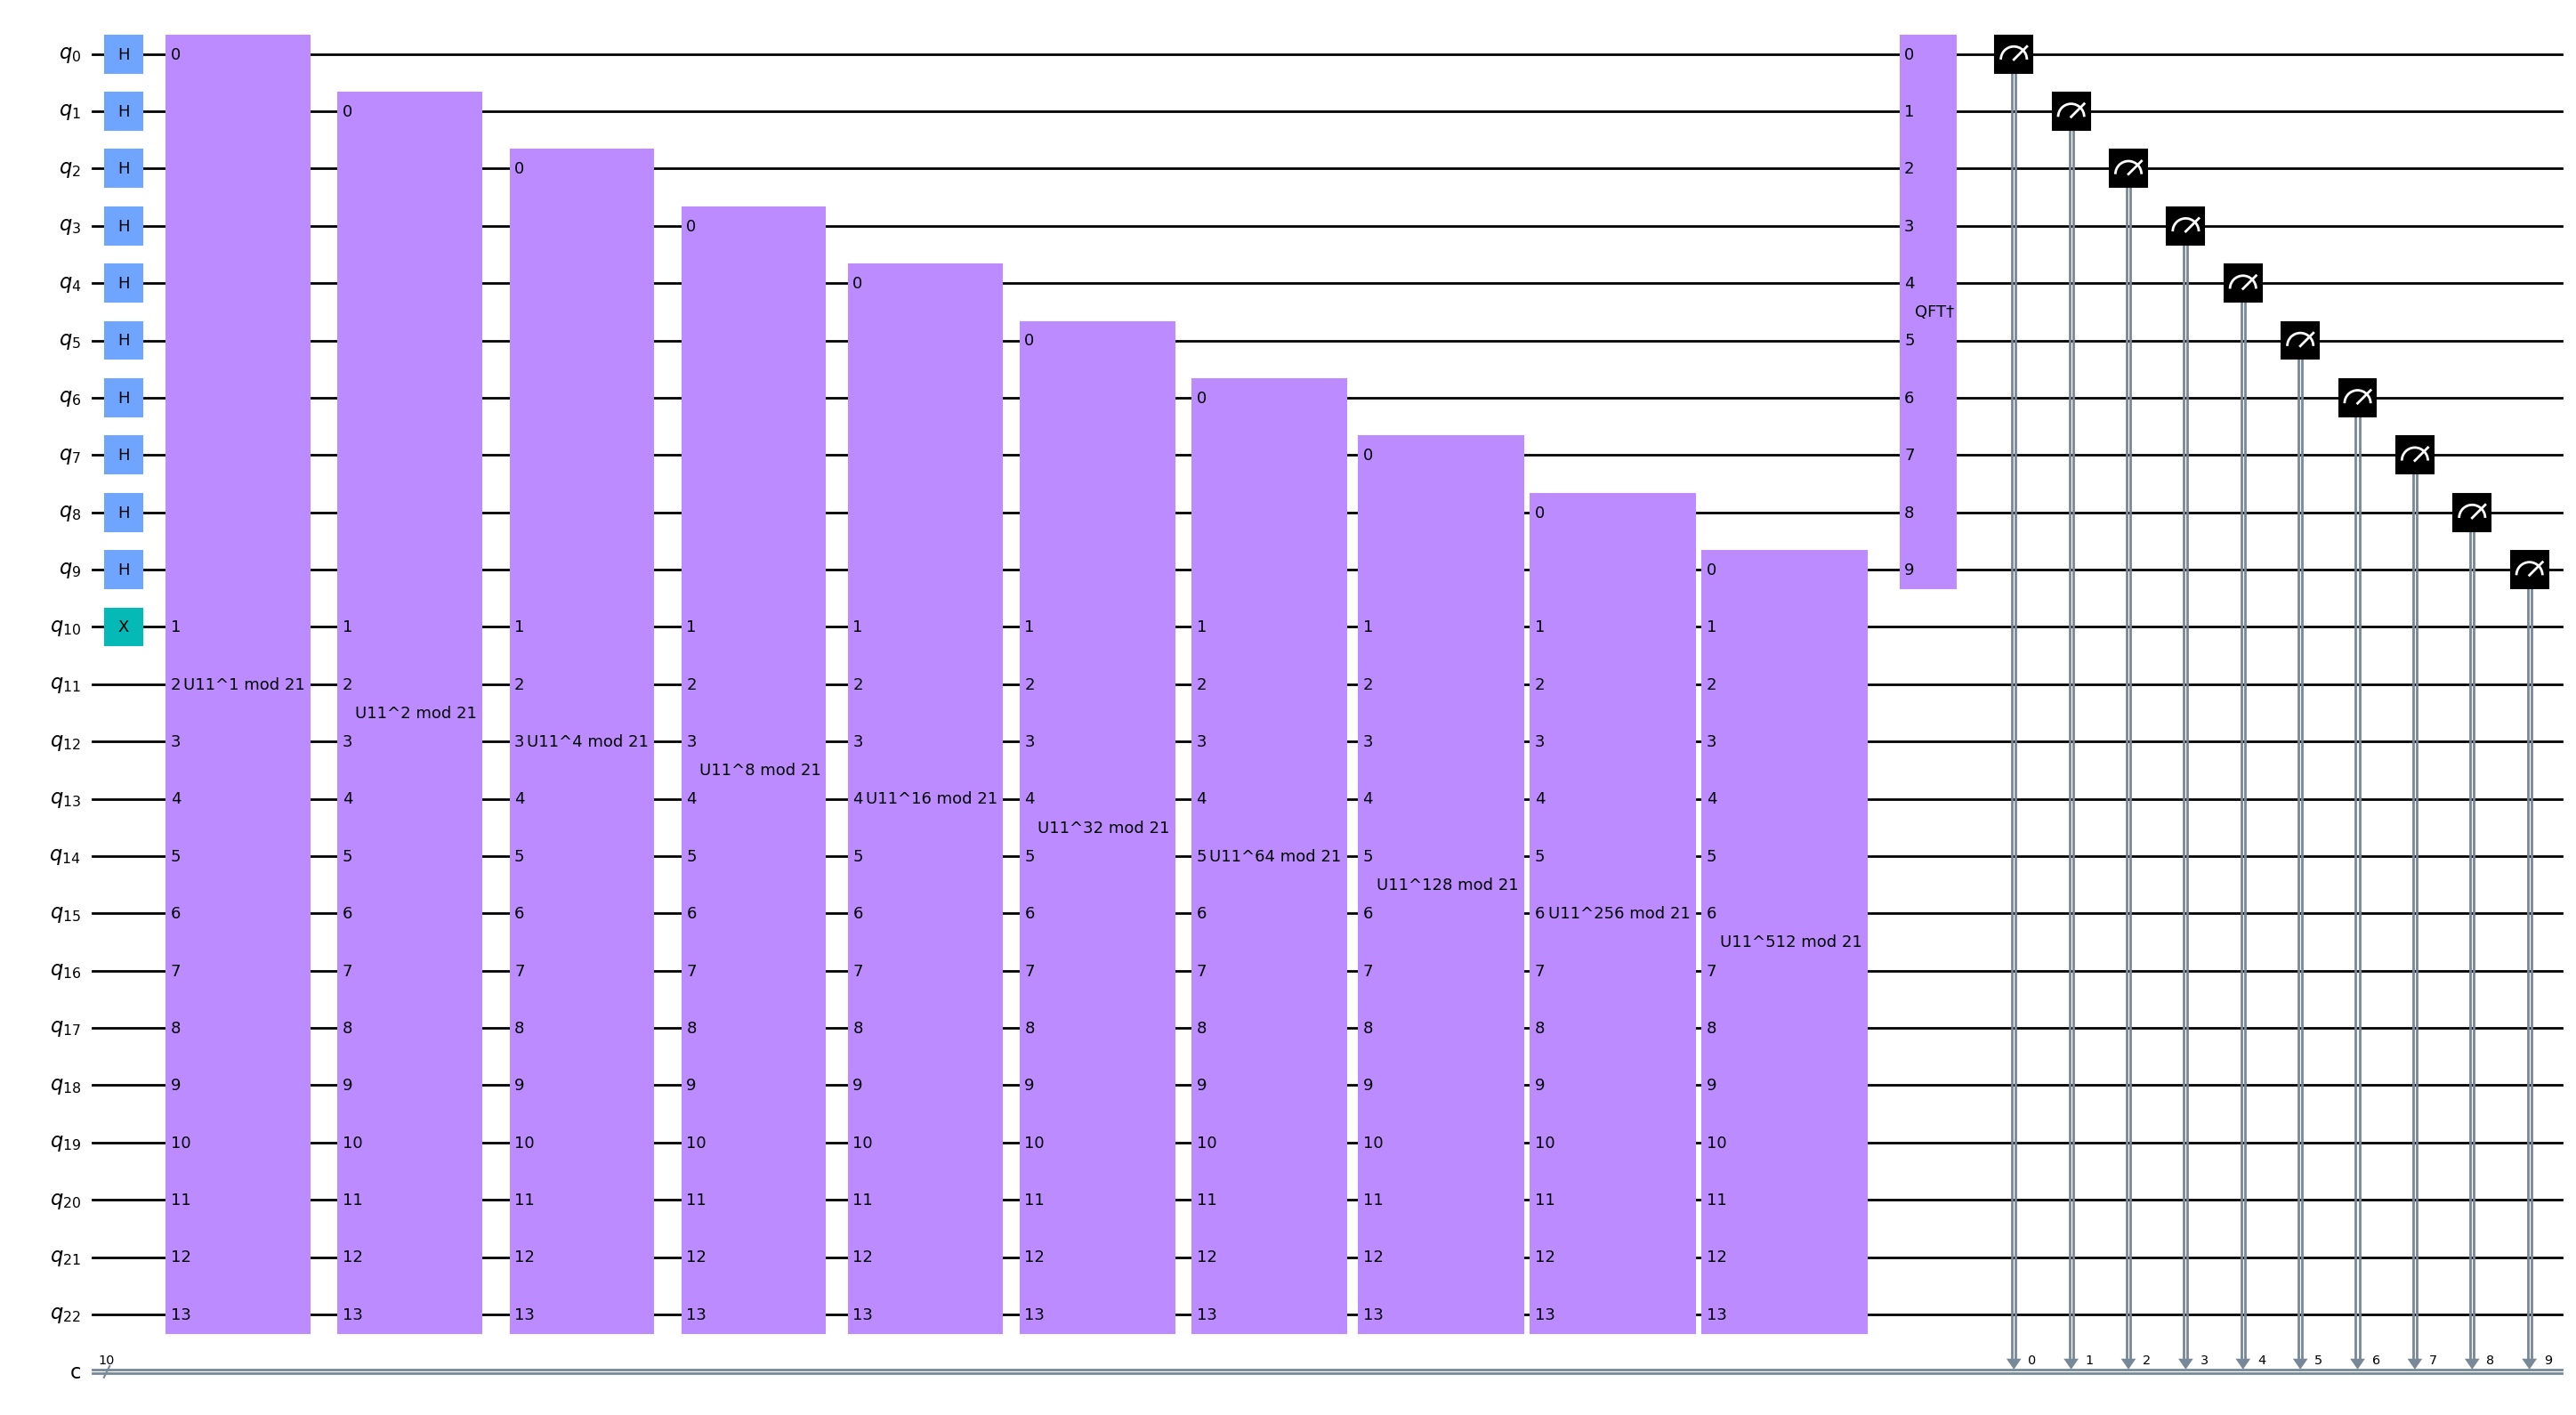

In [91]:
from shor_algo_adder_method import shor_circiut
import bit_functions
N = 21
a = 11
N_COUNT = 2*bit_functions.bit_length(N)

qc = shor_circiut(N, a)

qc.draw('mpl', fold = -1)


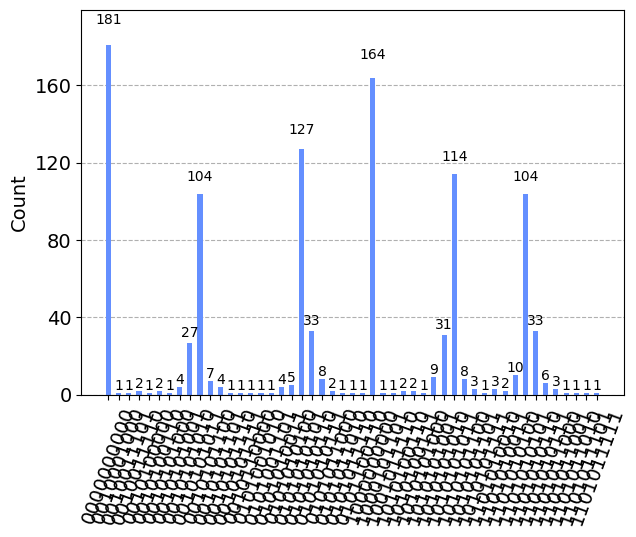

In [92]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = execute(t_qc, aer_sim).result().get_counts()
# counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [93]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

               Register Output            Phase
0   0010101001(bin) = 169(dec)  169/1024 = 0.17
1   0000000000(bin) =   0(dec)    0/1024 = 0.00
2   1101011000(bin) = 856(dec)  856/1024 = 0.84
3   0010101010(bin) = 170(dec)  170/1024 = 0.17
4   1101010101(bin) = 853(dec)  853/1024 = 0.83
5   0010101011(bin) = 171(dec)  171/1024 = 0.17
6   0101010101(bin) = 341(dec)  341/1024 = 0.33
7   1010101011(bin) = 683(dec)  683/1024 = 0.67
8   0010101100(bin) = 172(dec)  172/1024 = 0.17
9   1000000000(bin) = 512(dec)  512/1024 = 0.50
10  1101010110(bin) = 854(dec)  854/1024 = 0.83
11  1010100111(bin) = 679(dec)  679/1024 = 0.66
12  1010101001(bin) = 681(dec)  681/1024 = 0.67
13  1010101000(bin) = 680(dec)  680/1024 = 0.66
14  1010101010(bin) = 682(dec)  682/1024 = 0.67
15  0101010110(bin) = 342(dec)  342/1024 = 0.33
16  0101010011(bin) = 339(dec)  339/1024 = 0.33
17  1010101101(bin) = 685(dec)  685/1024 = 0.67
18  0010001000(bin) = 136(dec)  136/1024 = 0.13
19  0101010100(bin) = 340(dec)  340/1024

In [94]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


       Phase Fraction  Guess for r
0   0.165039      1/6            6
1   0.000000      0/1            1
2   0.835938      5/6            6
3   0.166016      1/6            6
4   0.833008      5/6            6
5   0.166992      1/6            6
6   0.333008      1/3            3
7   0.666992      2/3            3
8   0.167969      1/6            6
9   0.500000      1/2            2
10  0.833984      5/6            6
11  0.663086      2/3            3
12  0.665039      2/3            3
13  0.664062      2/3            3
14  0.666016      2/3            3
15  0.333984      1/3            3
16  0.331055      1/3            3
17  0.668945      2/3            3
18  0.132812     2/15           15
19  0.332031      1/3            3
20  0.667969      2/3            3
21  0.662109      2/3            3
22  0.337891      1/3            3
23  0.591797      3/5            5
24  0.832031      5/6            6
25  0.334961      1/3            3
26  0.543945     6/11           11
27  0.169922      1/

In [95]:
guesses = {x[2] for x in rows if x[2] != 1}

for curr_gess in guesses:
    if curr_gess % 2 == 0:
        num1 = int(a**(curr_gess/2)+1)
        num2 = int(a**(curr_gess/2)-1)

        q = np.gcd(num1, N)
        p = np.gcd(num2, N)

        print(f"for r = {curr_gess} factors are: {p}, {q}")


for r = 2 factors are: 1, 3
for r = 6 factors are: 7, 3
for r = 14 factors are: 1, 3


Transpailing the circuit:

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeAuckland #need to change to "
# from qiskit_ibm_runtime.fake_provider import FakeAuckland #" after qiskit 0.46
 
backend = FakeAuckland()

tran_circute = transpile(qc, backend, optimization_level = 0)

KeyboardInterrupt: 

In [ ]:
# result = execute(tran_circute, backend=backend).result()
result = backend.run(tran_circute)
print(result)

In [ ]:
res = result.result()

In [ ]:
plot_histogram(result.get_counts())

In [ ]:
tran_circute.draw(fold=-1)

In [ ]:

qc.draw(fold=-1, with_layout=False)

In [ ]:
from qiskit.tools.visualization import circuit_drawer
# tran_circute.draw( filename="shor_circuit.png")
circuit_drawer(tran_circute, output='mpl')

In [ ]:
counts = aer_sim.run(tran_circute).result().get_counts()
plot_histogram(counts)

In [ ]:
print(f"depth original circuit {qc.depth()}")
print(f"depth after transpiling {tran_circute.depth()}")

In [ ]:
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeAuckland #need to change to "from qiskit_ibm_runtime.fake_provider import FakeExample" after qiskit 0.46

fake_backend = FakeAuckland()

circ_no_bar = RemoveBarriers()(qc)

tran0 = transpile(circ_no_bar, backend=fake_backend, optimization_level=0)
# tran3 = transpile(circ_no_bar, backend=fake_backend, optimization_level=3)

result_basic = execute(circ_no_bar, backend=aer_sim).result()
# result_basic_fake = execute(circ_no_bar, backend=fake_backend).result()
# result_0 = execute(tran0, backend=fake_backend).result()
# result_3 = execute(tran3, backend=fake_backend).result()

# plot_histogram([result_basic.get_counts(), result_basic_fake.get_counts(), result_0.get_counts(), result_3.get_counts()], legend=['basic', "basic_fake", "level=0", "level=3"])


In [ ]:
result_basic_fake = execute(circ_no_bar, backend=fake_backend).result()



In [ ]:
result_0 = execute(tran0, backend=fake_backend).result()

In [ ]:
result_3 = execute(tran3, backend=fake_backend).result()

In [ ]:
depth_basic = circ_no_bar.depth()
depth0 = tran0.depth()
depth3 = tran3.depth()

plot_histogram({"basic":depth_basic, "level=0":depth0, "level=3":depth3})